In [1]:
import cpm
version = cpm.__version__
## if cpm is below 0.18.5, throw error
if version < "0.18.5":
    raise Exception("cpm version is too old, please update to 0.18.5 or later")
else:
    print(f"cpm version is up to date\nversion: {version}\nauthor: {cpm.__author__}")

cpm version is up to date
version: 0.19.0
author: Lenard Dome


# Example 2: Reinforcement learning with a two-armed bandit.

This is an **intermediate** level tutorial, where we assume that you are familiar with the basics of reinforcement learning and the two-armed bandit problem.
In this example, we will apply and fit a reinforcement learning model to a two-armed bandit problem.
The model will be consist of a $\epsilon$-greedy policy and a prediction error term.

In the following tutorial, we will use `prettyformatter` to print some nice and organised output in the Jupyter Notebook.
In your python script, you do not need to use `prettyformatter`.


## Two-armed bandits

Two-armed bandit is a two-alternative forced-choice reinforcement learning problem, part of the bigger set of multi-armed bandit problems. 
In these problems, the person is faced with multiple choices, each with a different degree of reward.
The goal of the person is to learn which choice is the best and to maximize the reward over time.
In this example, we will consider a two-armed bandit problem, where the person is faced with two choices (select an item on the left or the item on the right), each with a different reward.
There are 4 different items that can appear in combinations of two, and the reward for each item varies.
For example, if item 1 has a chance of 0.7 of giving a reward, then you can expect to receive a reward 70% of the time when you select item 1.
The problem is that the underlying structure of the item-reward mapping is unknown.


## Import the data

First, we will import the data and get it ready for the toolbox.

In [1]:
## toolbox and libraries
import cpm
import ipyparallel as ipp ## for parallel computing with ipython (specific for Jupyter Notebook)
import pandas as pd
import numpy

import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from prettyformatter import pprint

experiment = cpm.datasets.load_bandit_data()
experiment.head(10)

,ppt,trial,arm_left,arm_right,reward_left,reward_right,response,feedback
0,1,1,2,4,1,1,0,1
1,1,2,2,4,1,1,1,1
2,1,3,2,1,0,0,0,0
3,1,4,2,1,0,0,1,0
4,1,5,1,4,0,0,0,0
5,1,6,4,3,1,1,0,1
6,1,7,3,1,1,0,0,1
7,1,8,3,2,0,0,1,0
8,1,9,1,4,0,0,0,0
9,1,10,2,3,0,0,0,0


Let us look at what each column represents:

- `index`: variable to identify each row - this variable is clutter.
- `left`: the stimulus presented on the left side.
- `right`: the stimulus presented on the right side.
- `reward_left`: the reward received when the left stimulus is selected.
- `reward_right`: the reward received when the right stimulus is selected.
- `ppt`: the participant number.
- `responses`: the response of the participant (1 for right, 0 for left).

Here, we will quickly add a column `observed` to specify for the toolbox, what is the dependent variable we actually want to predict.



In [2]:
experiment['observed'] = experiment['response']

## The model description


Let each stimulus have an associated value, which is the expected reward that can be obtained from selecting that stimulus. Let also $Q(a)$ be the estimated value of action $a$. We set the starting value for all $Q(a)$ to be nonzero and equally distributed between all stimuli.

In each trial, $t$, there are two stimuli present, so $Q(a)$ could be $Q(\text{left})$ or $Q(\text{right})$, where the corresponding Q values are derived from the associated value of the stimuli present on the left or right.
More formally, we can say that the expected value of the action $a$ selected at time $t$ is given by:

\begin{equation}
Q_t(a) = \mathbb{E}[R_t | A_t = a]
\end{equation}

where $R_t$ is the reward received at time $t$, and $A_t$ is the action selected at time $t$. In each trial $t$, the Softmax choice rule (Bridle, 1990) will select an action (left or right) based on the following policy:

\begin{equation}
P(a_t) = \frac{e^{Q_{a,t} \beta}}{\sum_{i = 1}^{k}{e^{Q_{i,t} \beta}}}
\end{equation}

where $\beta$ is the inverse temperature parameter, also referred to as choice stochasticity, and $Q_{a,t}$ is the estimated value of the action $a$ at time $t$. $k$ is the number of actions available, and in our case, $k = 2$. The model uses the variant of the delta rule (Rescorla & Wagner, 1972; Rumelhart, Hinton & Williams, 1986) adapted for multi-armed bandit problems where each option has a single dimension (Barto & Sutton, 2018), reducing Rescorla-Wagner's summed error-term to the following equation, similar to single linear operators (Bush and Mosteller, 1955):


\begin{equation}
\Delta Q_t(A_t) = \alpha \times \Big[ R_t - Q_t(A_t) \Big]
\end{equation}


where $\alpha$ is the learning rate and $R_t$ is the reward received at time $t$, also called a teaching signal and sometimes annotated as $\lambda$. $A_t$ is the action chosen for the trial $t$. Then we update the Q-values, such as:

\begin{equation}
Q_{t+1}(A_t) = Q_t(A_t) + \Delta Q_t(A_t)
\end{equation}

## Building the model

In order to use the toolbox, you will have to specify **the computations for one single trial**.
Rest assured, you do not have to build the model from scratch.
We have fully-fledged models in `cpm.applications` that you can use, but we also have all the building blocks in `cpm.components` that you can use to build your own model.

### Parameters

Now, before we build the model, we also have to talk about the `cpm.Parameter` class.
This class is used to specify the parameters of the model, including various bounds and priors.
Let us specify the parameters for the model.

In [3]:
from cpm.generators import Parameters, Value

parameters = Parameters(
    # freely varying parameters are indicated by specifying priors
    alpha=Value(
        value=0.5,
        lower=1e-10,
        upper=1,
        prior="truncated_normal",
        args={"mean": 0.5, "sd": 0.25},
    ),
    temperature=Value(
        value=1,
        lower=0,
        upper=10,
        prior="truncated_normal",
        args={"mean": 5, "sd": 2.5},
    ),
    # everything without a prior is part of the initial state of the model or fixed constructs (e.g. exemplars in general-context models of categorization)
    values = numpy.array([0.25, 0.25, 0.25, 0.25]))

You can immediately see that we have two types of variables in the `Parameters` class: one with priors and one without.
The ones with defined priors are the ones we will estimate later on, they are freely varying parameters (alpha and temperature).
**All freely varying parameters have to be defined with priors**.

Parameters without priors are part of the initial state of the model, such as starting Q-values for each stimulus.
Here we initialized them at 0.25.

That was enough preparation, let us build a model.
The model will take in the parameters class and the data, and it will output all variables of interest we specify.

> **Note**: The model will take in a variable (as its second argument) that is in our case a row in the `pandas.DataFrame`, behaving as a `pandas.Series`.

In [6]:
import cpm
import ipyparallel as ipp  ## for parallel computing with ipython (specific for Jupyter Notebook)

@ipp.require("numpy")
def model(parameters, trial):
    # pull out the parameters
    alpha = parameters.alpha
    temperature = parameters.temperature
    values = numpy.array(parameters.values)
    
    # pull out the trial information
    stimulus = numpy.array([trial.arm_left, trial.arm_right]).astype(int)
    feedback = numpy.array([trial.reward_left, trial.reward_right])
    human_choice = trial.response.astype(int)

    # Equation 1. - get the value of each available action
    # Note that because python counts from 0, we need to shift
    # the stimulus identifiers by -1
    expected_rewards = values[stimulus - 1]
    # Equation 2.
    # calculate a policy based on the activations
    choice_rule = cpm.models.decision.Softmax(
        activations=expected_rewards,
        temperature=temperature
        )
    choice_rule.compute() # compute the policy
    # if the policy is NaN for an action, then we need to set it to 1
    # this corrects some numerical issues with python and infinities
    if numpy.isnan(choice_rule.policies).any():
        choice_rule.policies[numpy.isnan(choice_rule.policies)] = 1
    model_choice = choice_rule.choice() # get the choice based on the policy

    # get the received reward for the choice
    reward = feedback[human_choice]
    teacher = numpy.array([reward])
    # we now create a vector that tells our learning rule what...
    # ... stimulus to update according to the participant's choice
    what_to_update = numpy.zeros(4)
    chosen_stimulus = stimulus[human_choice] - 1
    what_to_update[chosen_stimulus] = 1

    # Equation 4.
    update = cpm.models.learning.SeparableRule(
                    weights=values,
                    feedback=teacher,
                    input=what_to_update,
                    alpha=alpha
                    )
    update.compute()
    # Equation 5.
    values += update.weights.flatten()
    # compile output
    output = {
        "trial"    : trial.trial.astype(int), # trial numbers
        "activation" : expected_rewards.flatten(), # expected reward of arms
        "policy"   : choice_rule.policies,       # policies
        "response" : model_choice,            # model's choice
        "reward"   : reward,                  # received reward
        "error"    : update.weights,          # prediction error
        "values"   : values,                  # updated values
        # dependent variable
        "dependent"  : numpy.array([choice_rule.policies[1]]),
    }
    return output

The important bit here is that everything we want to store must be specified in the model output.
There are also variables we want to update, such as the values, which again, we have to include in the model output.
They will be used by other methods in the toolbox to identify key variables.

The important part is the `dependent` key, which outputs the main thing we fit the model to later.

## Fitting to data

First we wrap our model specification into a `Wrapper`, that loops it through the data

In [7]:
from cpm.generators import Simulator, Wrapper

wrapper = Wrapper(model=model, parameters=parameters, data=experiment[experiment.ppt == 1])
wrapper.run()

/var/folders/w1/7prlf4xs12536zfppmztb1_m0000gn/T/ipykernel_28536/515481073.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  values = numpy.array(parameters.values)


Now we have ran the model on a single session, let's investagete the output.
`cpm` is great for this because everything that you might need to look at is stored inside the `Wrapper` object.

In [8]:
## print last trial
pd.Series(wrapper.simulation[len(wrapper.simulation) - 1])

trial                                                        96
activation                [0.6256103515625, 0.7441403864537506]
policy                 [0.47040213577587603, 0.529597864224124]
response                                                      1
reward                                                        0
error                   [[-0.0, -0.31280517578125, -0.0, -0.0]]
values        [0.7519550323486328, 0.31280517578125, 0.46469...
dependent                                   [0.529597864224124]
dtype: object

Maybe a better way to do this is to export the simulation details as a `pandas.DataFrame`:

In [9]:
output = wrapper.export() # export sim data into pandas dataframe
output.tail()

,trial_0,activation_0,activation_1,policy_0,policy_1,response_0,reward_0,error_0,error_1,error_2,error_3,values_0,values_1,values_2,values_3,dependent_0,ppt
91,92,0.751955,0.251221,0.622632,0.377368,1,1,0.0,0.374390,0.0,0.000000,0.751955,0.625610,0.464693,0.953123,0.377368,0
92,93,0.625610,0.953123,0.418846,0.581154,1,1,0.0,0.000000,0.0,0.023438,0.751955,0.625610,0.464693,0.976562,0.581154,0
93,94,0.751955,0.976562,0.444083,0.555917,1,0,-0.0,-0.000000,-0.0,-0.488281,0.751955,0.625610,0.464693,0.488281,0.555917,0
94,95,0.464693,0.488281,0.494103,0.505897,0,1,0.0,0.000000,0.0,0.255860,0.751955,0.625610,0.464693,0.744140,0.505897,0
95,96,0.625610,0.744140,0.470402,0.529598,1,0,-0.0,-0.312805,-0.0,-0.000000,0.751955,0.312805,0.464693,0.744140,0.529598,0


### Fitting the model

Now that we have the model, we can fit it to the data.

In [10]:
from cpm.optimisation import minimise, FminBound

fit = FminBound(
    model=wrapper,  # Wrapper class with the model we specified from before
    data=experiment.groupby('ppt'),  # the data as a list of dictionaries
    minimisation=minimise.LogLikelihood.bernoulli,
    parallel=True,
    libraries=["numpy", "cpm", "pandas"],
    cl=5,
    prior=False,
    ppt_identifier="ppt",
    display=False,
    number_of_starts=5,
    # everything below is optional and passed directly to the scipy implementation of the optimiser
    approx_grad=True

)

fit.optimise()

Starting optimization 1/5 from [0.81931522 3.77687477]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

Starting optimization 2/5 from [0.226663   3.48785914]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

Starting optimization 3/5 from [0.62074252 8.63370111]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

Starting optimization 4/5 from [0.96157243 5.3749175 ]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

Starting optimization 5/5 from [0.37482636 7.59756641]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

In [11]:
optimisation = fit.export()
optimisation.to_csv('bandit_optimised.csv')
optimisation

,x_0,x_1,grad_0,grad_1,task,funcalls,nit,warnflag,hessian_0,hessian_1,hessian_2,hessian_3,ppt,fun
0,7.639538e-02,4.943492,-3.836931e-05,-2.557954e-05,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,39,11,0,1038.584729,27.069378,27.069378,0.890569,1,48.885637
1,5.689276e-02,6.042451,-5.684342e-06,0.000000e+00,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,51,13,0,2153.675873,35.756083,35.756083,0.629378,2,47.533037
2,1.000000e-10,0.000000,0.000000e+00,0.000000e+00,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,6,1,0,0.688812,-40.428546,-40.428546,0.000612,3,66.542129
3,4.465224e-01,1.775728,1.421085e-06,0.000000e+00,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,51,11,0,45.754551,4.659358,4.659358,3.575177,4,59.814704
4,9.066256e-02,10.000000,-3.552714e-07,-8.154309e-01,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,63,12,0,1792.445900,9.953953,9.953953,0.262456,5,23.110100
5,1.000000e-10,0.000000,0.000000e+00,0.000000e+00,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,6,1,0,0.862864,-57.128419,-57.128419,0.000585,6,66.542129
6,1.278972e-01,4.204484,7.105427e-07,1.421085e-06,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,45,11,0,266.972579,13.598916,13.598916,1.231780,7,49.503374
7,3.371552e-01,2.836729,-2.842171e-06,0.000000e+00,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,30,8,0,62.884574,5.283087,5.283087,2.532646,8,51.435683
8,2.414050e-02,10.000000,0.000000e+00,-1.847553e-02,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,69,17,0,15382.111423,45.921132,45.921132,0.131934,9,57.344351
9,2.885396e-01,1.416185,1.968203e-04,2.415845e-05,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,51,10,0,47.786196,4.427587,4.427587,2.556343,10,63.766870


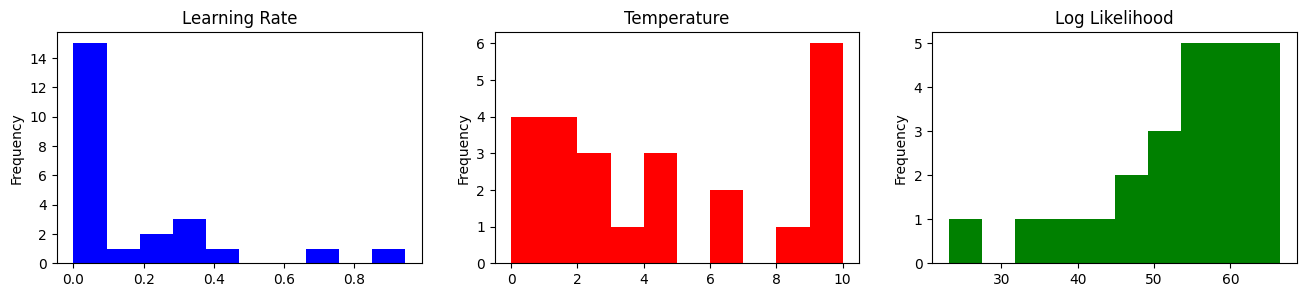

In [12]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 3))  # 1 row, 2 columns, and optional figure size

# Plot on the first subplot with a specific color
optimisation.x_0.plot(kind="hist", label="Learning Rate", color="blue", ax=axs[0])
axs[0].set_title('Learning Rate')

# Plot on the second subplot with a different color
optimisation.x_1.plot(kind="hist", label="Temperature", color="red", ax=axs[1])
axs[1].set_title('Temperature')

optimisation.fun.plot(kind="hist", label="Negative Log Likelihood", color="green", ax=axs[2])
axs[2].set_title('Log Likelihood')

# Display the plot
plt.show()

## Simulation

We can instantly simulate model output from these results by using the `cpm.generator.Simulator` class.

In [13]:
from cpm.generators import Simulator

simulator = Simulator(wrapper=wrapper,
                      parameters=fit.parameters, # parameters from the optimiser object is directly accessible for simulation
                      data=experiment.groupby("ppt")) # data grouped by participants
simulator.run()


/var/folders/w1/7prlf4xs12536zfppmztb1_m0000gn/T/ipykernel_28536/515481073.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  values = numpy.array(parameters.values)
/var/folders/w1/7prlf4xs12536zfppmztb1_m0000gn/T/ipykernel_28536/515481073.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  values = numpy.array(parameters.values)
/var/folders/w1/7prlf4xs12536zfppmztb1_m0000gn/T/ipykernel_28536/515481073.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  values = numpy.array(parameters.values)
/var/folders/w1/7prlf4xs12536zfppmztb1_m0000gn/T/ipykernel_28536/515481073.py:9: DeprecationWarning: __array__ implementatio

In [14]:
simulation_data = simulator.export()
simulation_data.to_csv('bandit_simulation.csv')
simulation_data.tail()

,trial_0,activation_0,activation_1,policy_0,policy_1,response_0,reward_0,error_0,error_1,error_2,error_3,values_0,values_1,values_2,values_3,dependent_0,ppt
2299,92,0.213717,0.320806,0.262146,0.737854,1,0,-0.000000,-0.008165,-0.000000,-0.000000,0.213717,0.312641,0.424581,0.484535,0.737854,914
2300,93,0.213717,0.484535,0.068050,0.931950,1,1,0.000000,0.000000,0.000000,0.013119,0.213717,0.312641,0.424581,0.497654,0.931950,914
2301,94,0.213717,0.312641,0.277690,0.722310,0,1,0.020011,0.000000,0.000000,0.000000,0.233728,0.312641,0.424581,0.497654,0.722310,914
2302,95,0.497654,0.424581,0.669547,0.330453,0,0,-0.000000,-0.000000,-0.010806,-0.000000,0.233728,0.312641,0.413776,0.497654,0.330453,914
2303,96,0.497654,0.413776,0.692228,0.307772,0,1,0.000000,0.000000,0.014919,0.000000,0.233728,0.312641,0.428695,0.497654,0.307772,914


In [15]:
left_option = experiment.arm_left
right_option = experiment.arm_right
model_chosen_left = 1 - simulation_data.response_0
model_chosen_right = simulation_data.response_0
ppt = simulation_data.ppt
trials = simulation_data.trial_0

left = pd.DataFrame({
    "stimulus": left_option,
    "response": model_chosen_left,
    "trial": trials,
    "ppt": ppt
})

right = pd.DataFrame({
    "stimulus": right_option,
    "response": model_chosen_right,
    "trial": trials,
    "ppt": ppt
})

# # print(stimulus.shape, response.shape, trial.shape)
plot_data = pd.concat([left, right], axis=0).sort_values(by="trial")


In [23]:
grouped = plot_data.groupby(['stimulus', 'trial']).mean().reset_index()
grouped.columns = ['stimulus', 'trial', 'response', 'ppt']
## calculate rolling mean
grouped['response_mean'] = grouped.groupby('stimulus')['response'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
grouped['response_std'] = grouped.groupby('stimulus')['response'].transform(lambda x: x.rolling(window=10, min_periods=1).std())

## rescale for each trial
grouped

,stimulus,trial,response,ppt,response_mean,response_std
0,1,1,0.571429,268.357143,0.571429,NaN
1,1,2,0.636364,92.090909,0.603896,0.045916
2,1,3,0.600000,189.333333,0.602597,0.032545
3,1,4,0.461538,78.846154,0.567333,0.075369
4,1,5,0.250000,84.416667,0.503866,0.156206
...,...,...,...,...,...,...
379,4,92,0.833333,85.333333,0.763975,0.144026
380,4,93,0.866667,189.266667,0.777309,0.147015
381,4,94,0.750000,84.500000,0.777309,0.147015
382,4,95,0.750000,234.375000,0.752309,0.124465


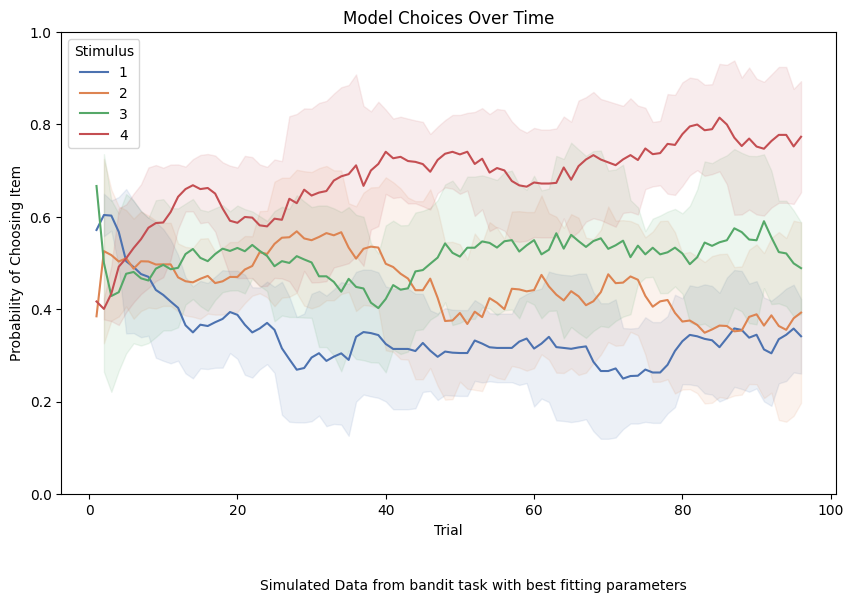

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn is used for easy color palette access


# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Get a list of unique stimuli to iterate over
unique_stimuli = grouped['stimulus'].unique()

# Generate a color palette with the same number of colors as there are unique stimuli
colors = sns.color_palette("deep", len(unique_stimuli))

# Iterate over each unique stimulus
for stimulus, color in zip(unique_stimuli, colors):
    # Filter the grouped DataFrame for the current stimulus
    df_subset = grouped[grouped['stimulus'] == stimulus]
    
    # Plot each subset with its corresponding color
    ax.plot(df_subset['trial'], df_subset['response_mean'], label=stimulus, color=color)
    # Plot the standard deviation as a shaded region around the mean
    ax.fill_between(df_subset['trial'], df_subset['response_mean'] - df_subset['response_std'], df_subset['response_mean'] + df_subset['response_std'], color=color, alpha=0.1)

    # Scale y axis to be between 0 and 1
    ax.set_ylim([0, 1])
    # Add a title and labels
    ax.set_title('Model Choices Over Time')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Probability of Choosing Item')

# Add legend to distinguish different lines
ax.legend(title='Stimulus')
# Add caption
plt.figtext(0.75, -0.05, '\n\nSimulated Data from bandit task with best fitting parameters', horizontalalignment='right')

# Show the plot
plt.show()